#  Flood Segmentation 

###  Project Overview
This notebook is the **starting point** for the flood segmentation task using multispectral satellite imagery.

We aim to:
- Explore and understand the dataset (12-band images + binary masks).
- Visualize different bands to identify water features.
- Prepare the data for training a deep learning segmentation model (U-Net / DeepLabV3+).



###  Dataset Info
- Each image contains **12 bands** (multispectral data).
- Each mask is a **binary image**:  
  `1` = water/flood, `0` = no water.
- Image dimensions: **128 x 128**
- All data is organized in the `data/raw/` folder.



###  Tasks in this notebook:
- Load sample images and masks.
- Display all 12 bands as grayscale images.
- Plot pixel distributions (histograms).
- Visualize masks and overlay them if needed.



###  Outcome
By the end of this notebook, we will have:
- A strong understanding of the input data structure.
- Insights into which bands are most useful for water detection.
- Cleaned and visualized data ready for preprocessing and modeling.



 Author: Hassan Abdul-Razeq  ||  Date: July 2025


#  Import Libraries

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rasterio
from PIL import Image

import sys
import os
sys.path.append(os.path.abspath('..'))
%load_ext autoreload
%autoreload 2



# Load Data Image and Label

In [2]:
from src.data_utils import read_image

In [3]:
image_path = '../data/raw/images/100.tif'

img=read_image(image_path)
img

c:\Users\digital\AppData\Local\Programs\Python\Python310\lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


array([[[ 577,  567,  590, ...,  701,  639,  601],
        [ 559,  617,  559, ...,  675,  648,  705],
        [ 539,  640,  561, ...,  761,  770,  856],
        ...,
        [ 544,  594,  639, ...,  656,  643,  638],
        [ 550,  605,  634, ...,  689,  640,  658],
        [ 604,  627,  616, ...,  620,  596,  640]],

       [[ 717,  730,  730, ...,  867,  775,  722],
        [ 687,  783,  708, ...,  824,  778,  861],
        [ 655,  793,  722, ...,  933,  950, 1053],
        ...,
        [ 663,  715,  772, ...,  824,  807,  801],
        [ 672,  737,  751, ...,  857,  809,  831],
        [ 733,  764,  734, ...,  787,  754,  808]],

       [[1109, 1157, 1136, ..., 1350, 1213, 1130],
        [1076, 1168, 1126, ..., 1305, 1250, 1358],
        [1002, 1194, 1163, ..., 1471, 1492, 1670],
        ...,
        [1052, 1117, 1192, ..., 1248, 1237, 1216],
        [1058, 1143, 1152, ..., 1288, 1220, 1269],
        [1152, 1179, 1135, ..., 1205, 1156, 1273]],

       ...,

       [[ 120,  120,  12

In [4]:
img.shape

(12, 128, 128)

# Data Visualization

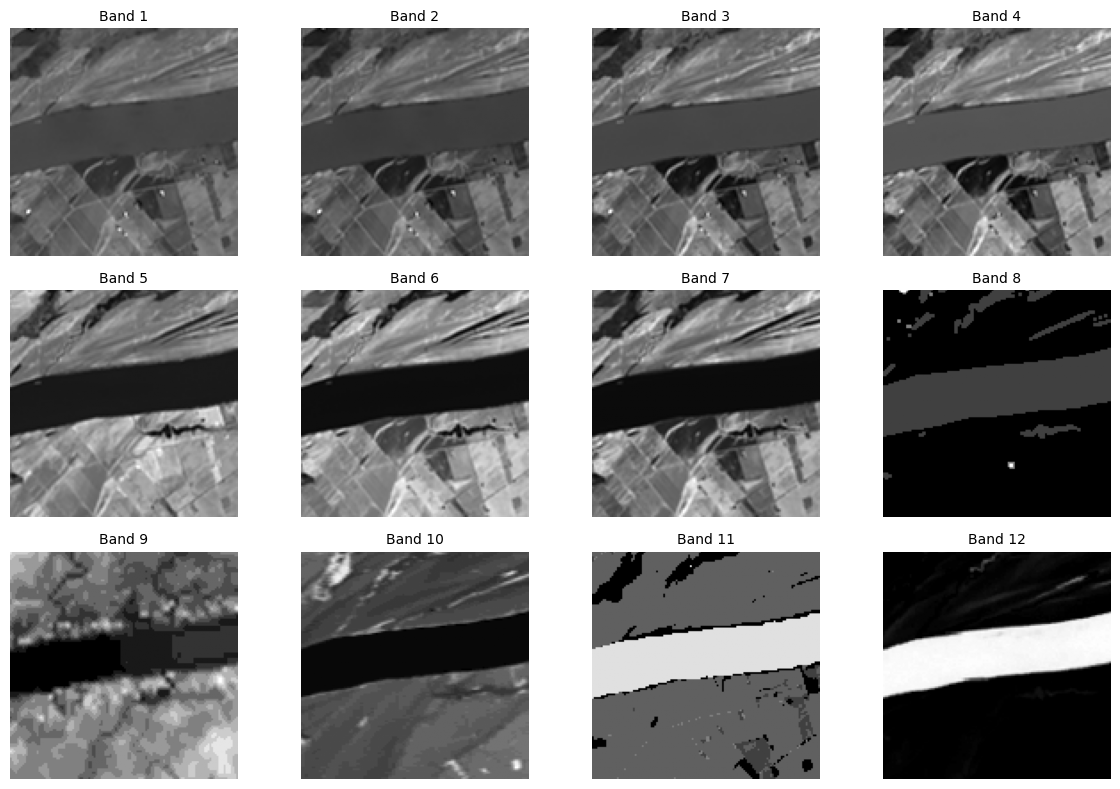

In [5]:
# Displaying the image bands
num_bands = img.shape[0]

rows = 3
cols = 4

plt.figure(figsize=(12, 8))

for i in range(num_bands):
    plt.subplot(rows, cols, i + 1)  
    plt.imshow(img[i], cmap='gray') 
    plt.title(f'Band {i + 1}', fontsize=10)
    plt.axis('off') 

plt.tight_layout()
plt.show()


## Display labels 

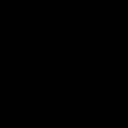

In [6]:
lebels_path = '../data/raw/labels/100.png'
labels = Image.open(lebels_path).convert('L')  # Convert to grayscale
labels


In [7]:
# convert labels to numpy array
lab_np = np.array(labels)
lab_np


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [8]:

lab_np.shape


(128, 128)

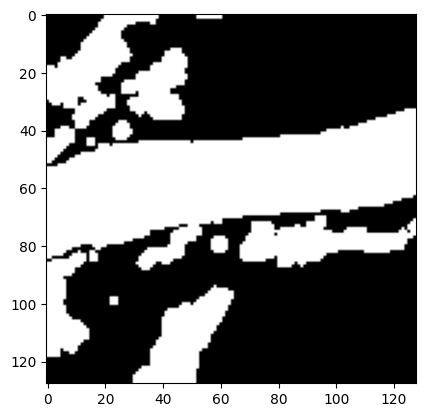

In [9]:
plt.imshow(lab_np, cmap='gray')

In [10]:
x=np.array(img)
y=np.array(lab_np)

In [11]:
x = np.moveaxis(x, 0, -1)# reshape



In [12]:
x.shape ,y.shape  

((128, 128, 12), (128, 128))

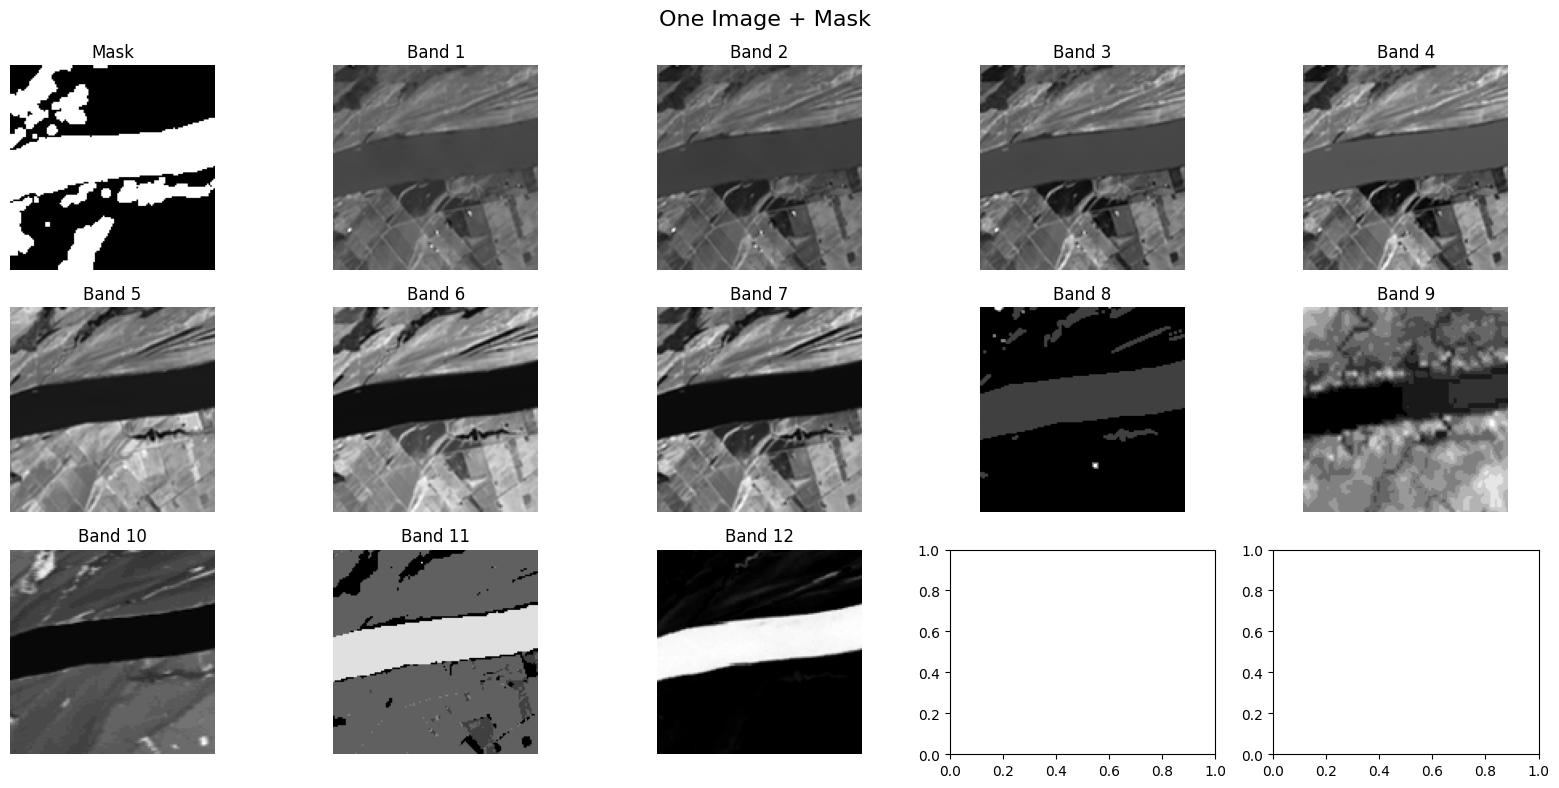

In [21]:
from src.visualize_utils import show_single_image_all_bands,show_image_all_bands,visualize_image_NDWI
show_single_image_all_bands(x,y)

In [32]:

print("Image shape:", x.shape) 
print("Label shape:", y.shape)    


Image shape: (128, 128, 12)
Label shape: (128, 128)


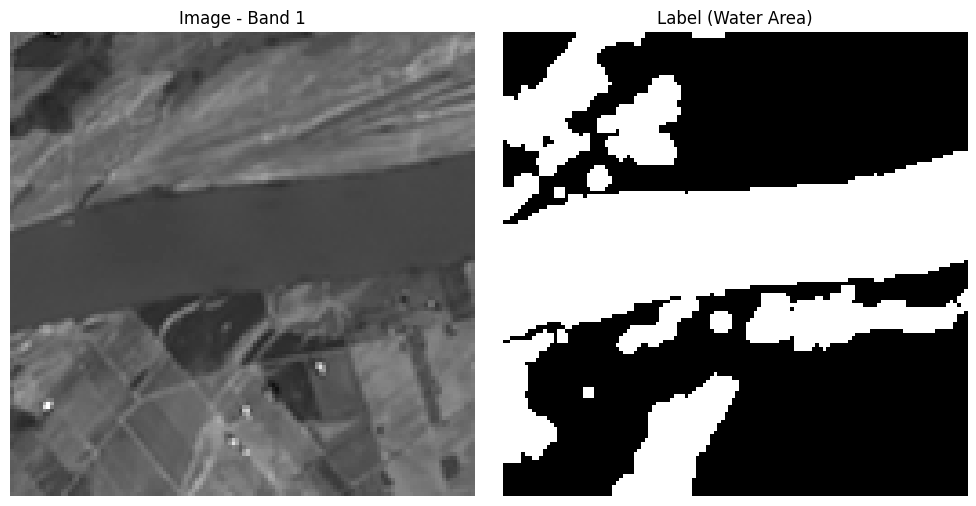

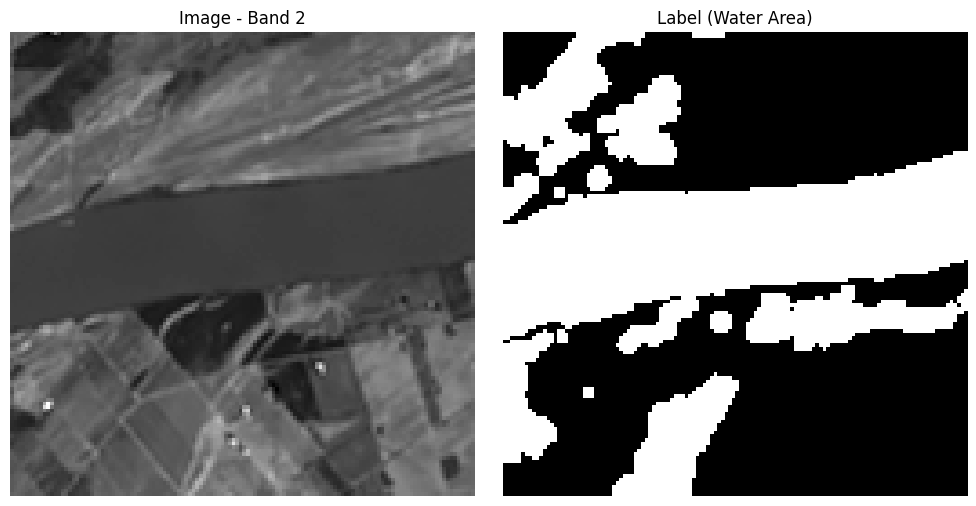

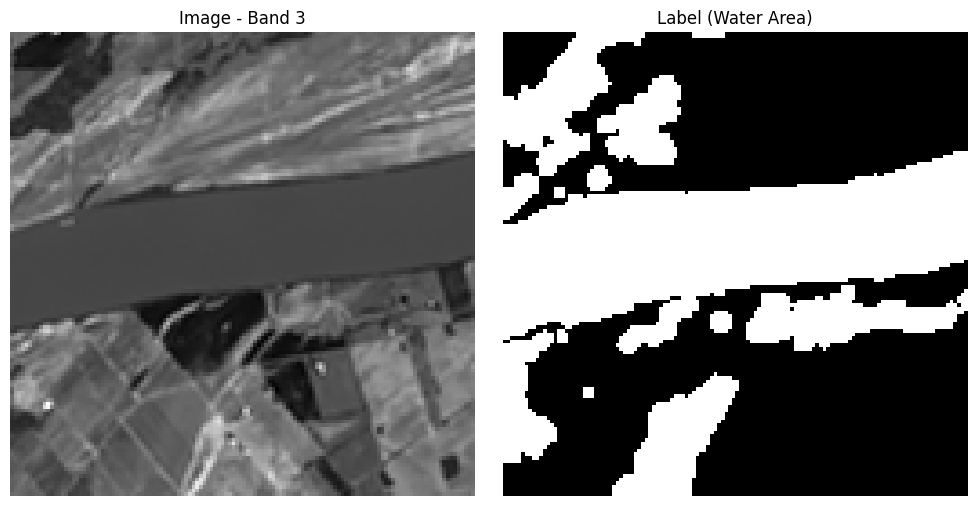

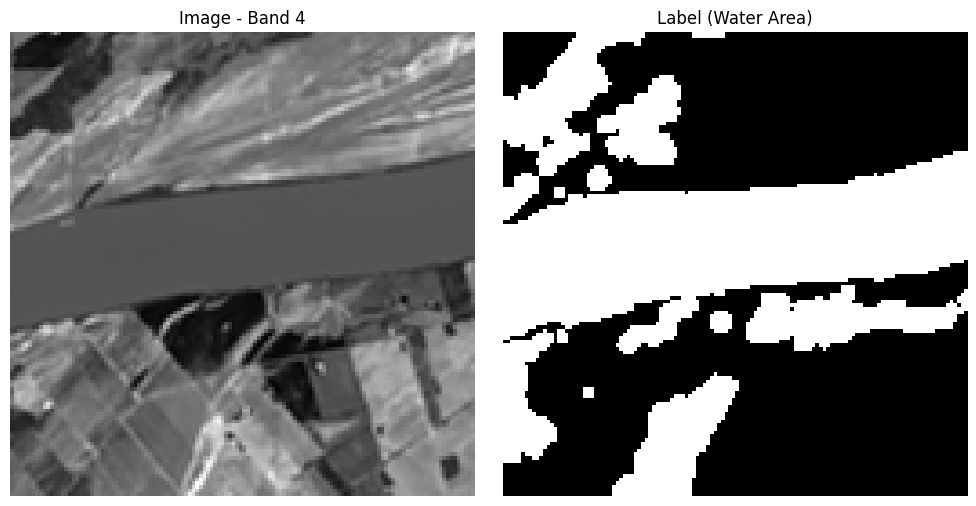

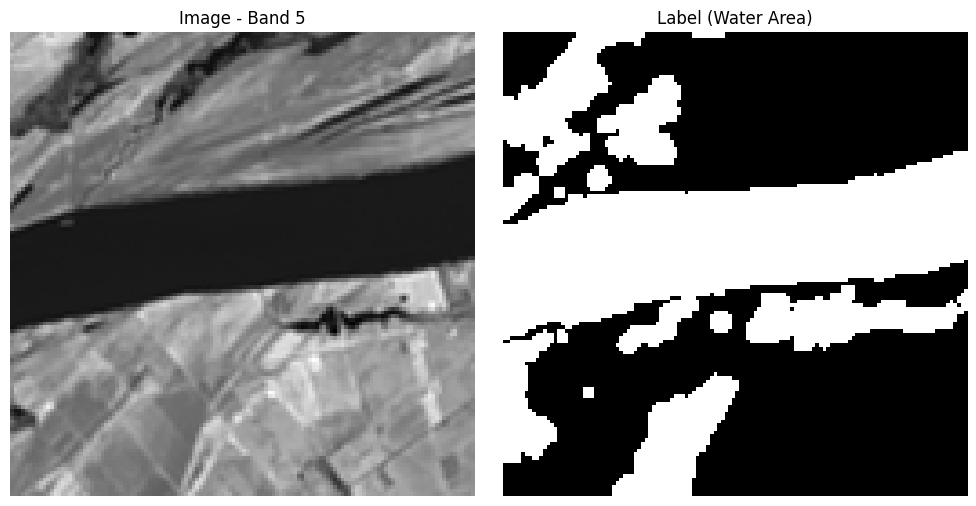

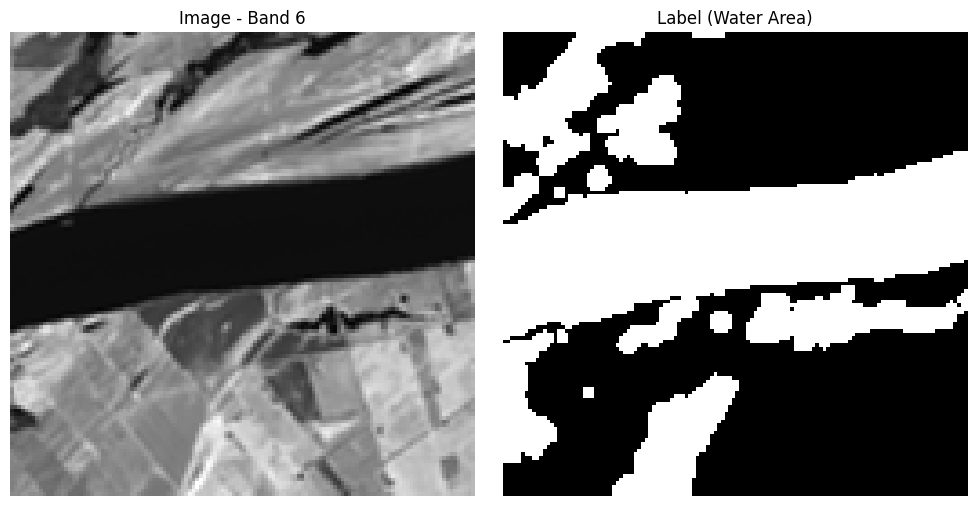

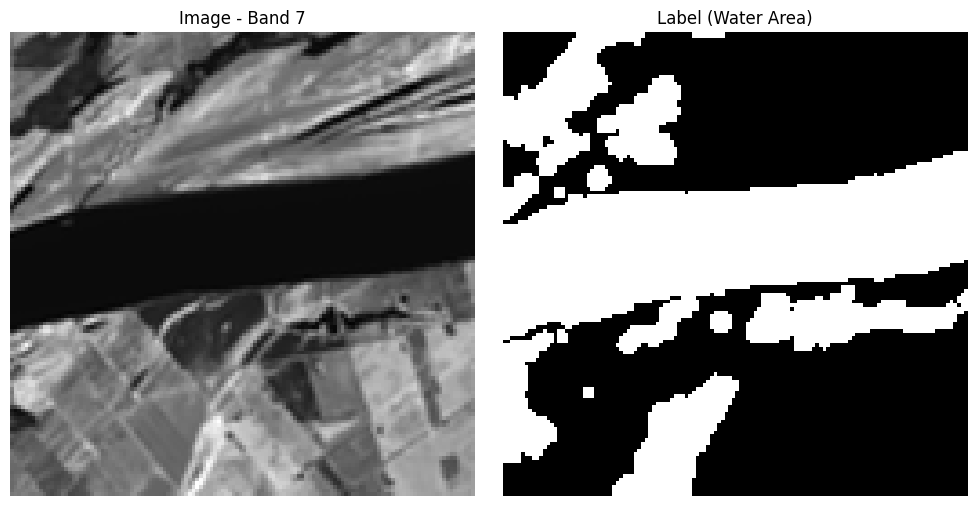

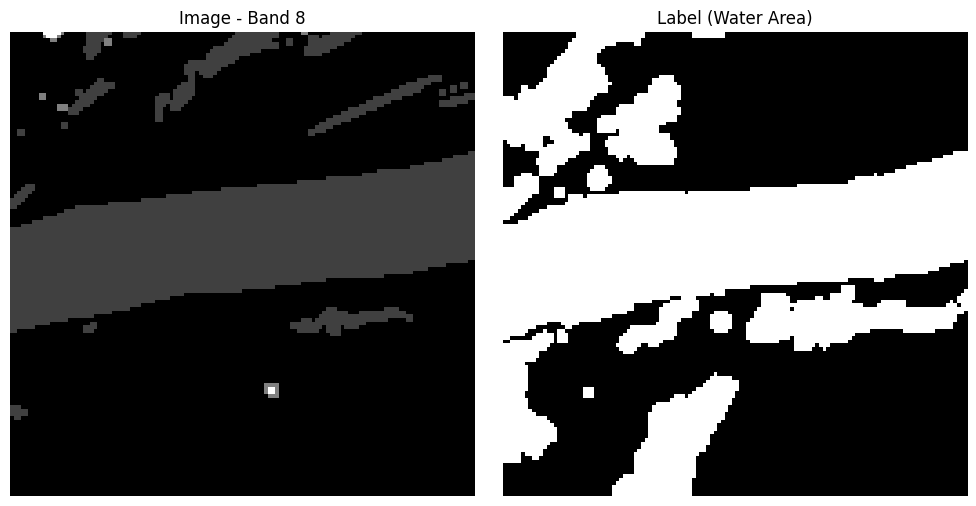

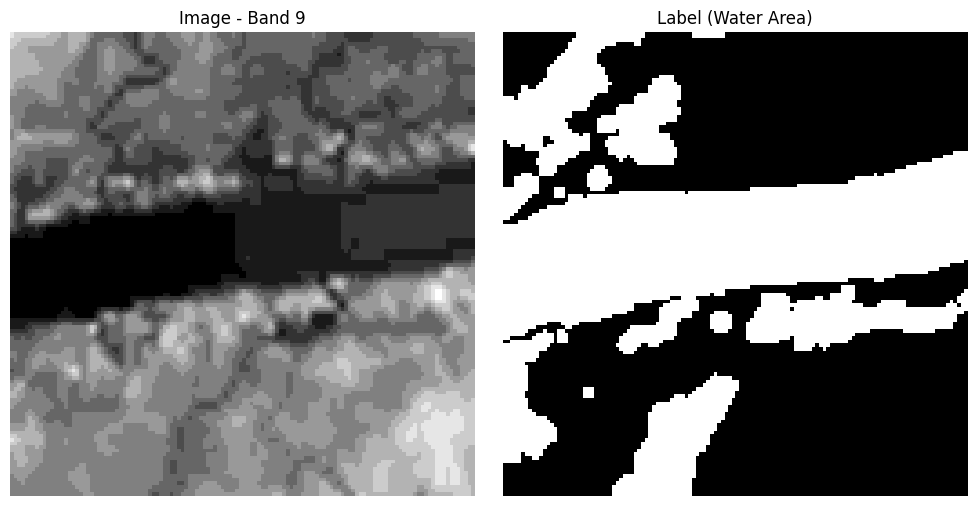

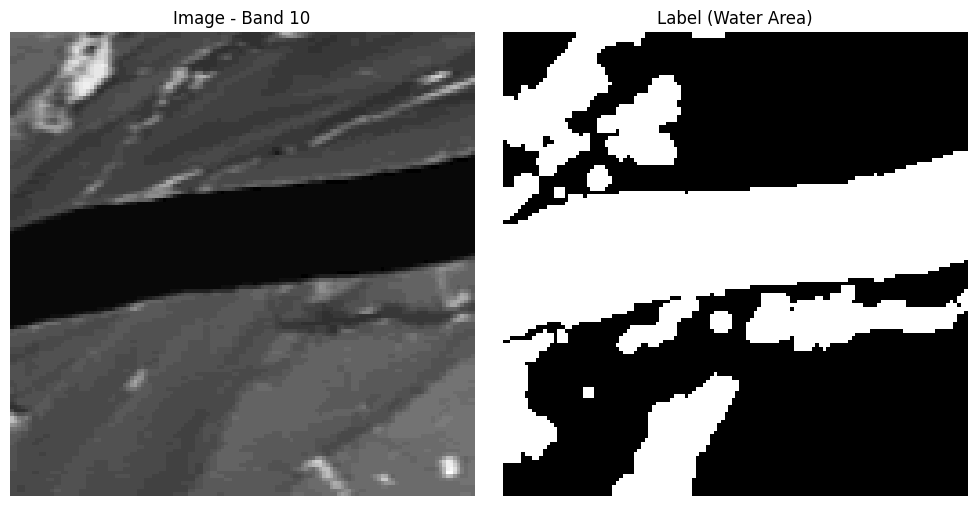

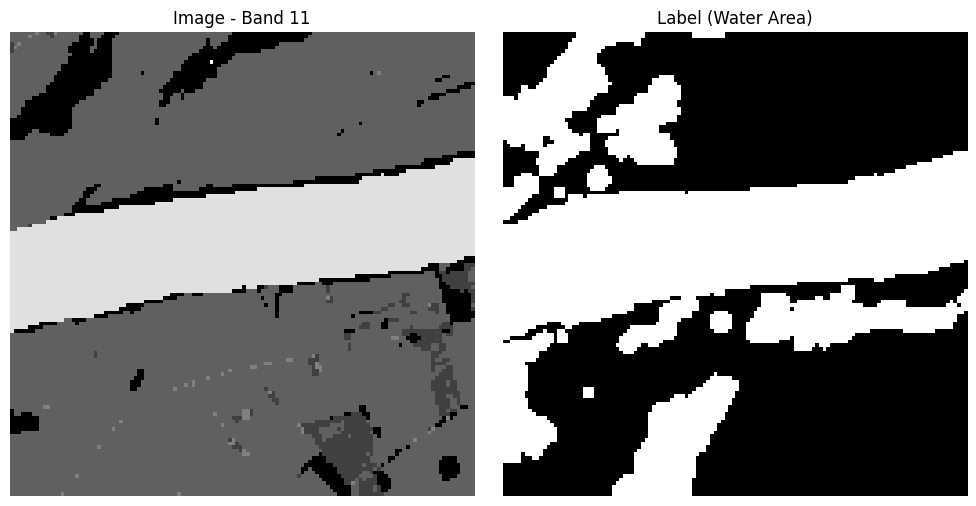

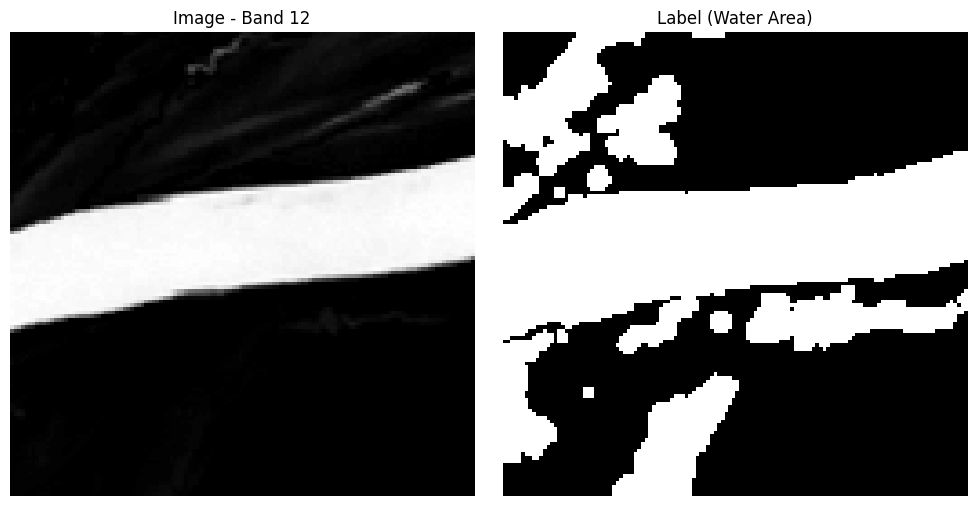

In [ ]:
from src.data_utils import visualize_image_and_label
for i in range(12):
    visualize_image_and_label(x,y,i)

# `Data Preparation`

# Load All Images and Labels into NumPy Arrays

In [33]:
# Get the paths of image and label files
image_dir = '../data/raw/images'
label_dir = '../data/raw/labels'

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.png')])
print("image files:", image_files)
print("label files:", label_files)


image files: ['0.tif', '1.tif', '10.tif', '100.tif', '101.tif', '102.tif', '103.tif', '104.tif', '105.tif', '106.tif', '107.tif', '108.tif', '109.tif', '11.tif', '110.tif', '111.tif', '112.tif', '113.tif', '114.tif', '115.tif', '116.tif', '117.tif', '118.tif', '119.tif', '12.tif', '120.tif', '121.tif', '122.tif', '123.tif', '124.tif', '125.tif', '126.tif', '127.tif', '128.tif', '129.tif', '13.tif', '130.tif', '131.tif', '132.tif', '133.tif', '134.tif', '135.tif', '136.tif', '137.tif', '138.tif', '139.tif', '14.tif', '140.tif', '141.tif', '142.tif', '143.tif', '144.tif', '145.tif', '146.tif', '147.tif', '148.tif', '149.tif', '15.tif', '150.tif', '151.tif', '152.tif', '153.tif', '154.tif', '155.tif', '156.tif', '157.tif', '158.tif', '159.tif', '16.tif', '160.tif', '161.tif', '162.tif', '163.tif', '164.tif', '165.tif', '166.tif', '167.tif', '168.tif', '169.tif', '17.tif', '170.tif', '171.tif', '172.tif', '173.tif', '174.tif', '175.tif', '176.tif', '177.tif', '178.tif', '179.tif', '18.tif'

In [34]:
print ("images number :", len(image_files))
print ("image_labels number :", len(label_files))

images number : 306
image_labels number : 456


note equals 

In [35]:
num_samples = len(image_files)

# Get paths
image_paths = [os.path.join(image_dir, f"{i}.tif") for i in range(num_samples)]
label_paths = [os.path.join(label_dir, f"{i}.png") for i in range(num_samples)]

# Check a few samples
print("Sample image path:", image_paths[300])
print("Sample label path:", label_paths[300])


Sample image path: ../data/raw/images\300.tif
Sample label path: ../data/raw/labels\300.png


In [36]:
print("shape of image:", len(image_paths))
print("shape of label:", len(label_paths))

shape of image: 306
shape of label: 306


In [37]:

from tqdm import tqdm  # for progress bar
from src.normalization import normalize, normalize_per_band


# Initialize empty lists to hold image and label data
X = []
Y = []

# Loop over all file pairs
for img_path, lbl_path in tqdm(zip(image_paths, label_paths), total=len(image_paths)):
    # --- Read the multispectral image ---
    with rasterio.open(img_path) as src:
        image = src.read()  # shape: (12, 128, 128)
    
    # Move channels to last dimension (H, W, C)
    image = np.moveaxis(image, 0, -1)  # shape: (128, 128, 12)
    
    # Normalize pixel values to [0, 1]
    #image = normalize(np.array(image,'float'))
    image = normalize_per_band(image)


    # --- Read the label (binary label) ---
    label = Image.open(lbl_path).convert('L')  # grayscale image
    label = np.array(label)  # shape: (128, 128)
    label = (label > 0).astype(np.uint8)  # convert to binary 0 or 1
    label = np.expand_dims(label, axis=-1)  # shape: (128, 128, 1)

    # Append to lists
    X.append(image)
    Y.append(label)


  0%|          | 0/306 [00:00<?, ?it/s]c:\Users\digital\AppData\Local\Programs\Python\Python310\lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 306/306 [00:14<00:00, 21.39it/s]


In [ ]:
X

[array([[[0.22586873, 0.08695652, 0.06811989, ..., 0.62068963,
          0.875     , 0.        ],
         [0.24710424, 0.07894737, 0.06902815, ..., 0.62068963,
          0.875     , 0.        ],
         [0.24710424, 0.08924485, 0.08174387, ..., 0.625     ,
          0.25      , 0.        ],
         ...,
         [0.5057915 , 0.29977116, 0.41144413, ..., 0.36206895,
          0.        , 0.        ],
         [0.5057915 , 0.30778033, 0.43687558, ..., 0.33620688,
          0.        , 0.        ],
         [0.49227798, 0.2951945 , 0.37965485, ..., 0.32327586,
          0.        , 0.        ]],
 
        [[0.3069498 , 0.16361555, 0.22252497, ..., 0.63793105,
          0.875     , 0.        ],
         [0.26833978, 0.1521739 , 0.19618529, ..., 0.64224136,
          0.875     , 0.        ],
         [0.26833978, 0.16475973, 0.19709355, ..., 0.6508621 ,
          0.        , 0.        ],
         ...,
         [0.6138996 , 0.3832952 , 0.4595822 , ..., 0.32327586,
          0.        , 0.

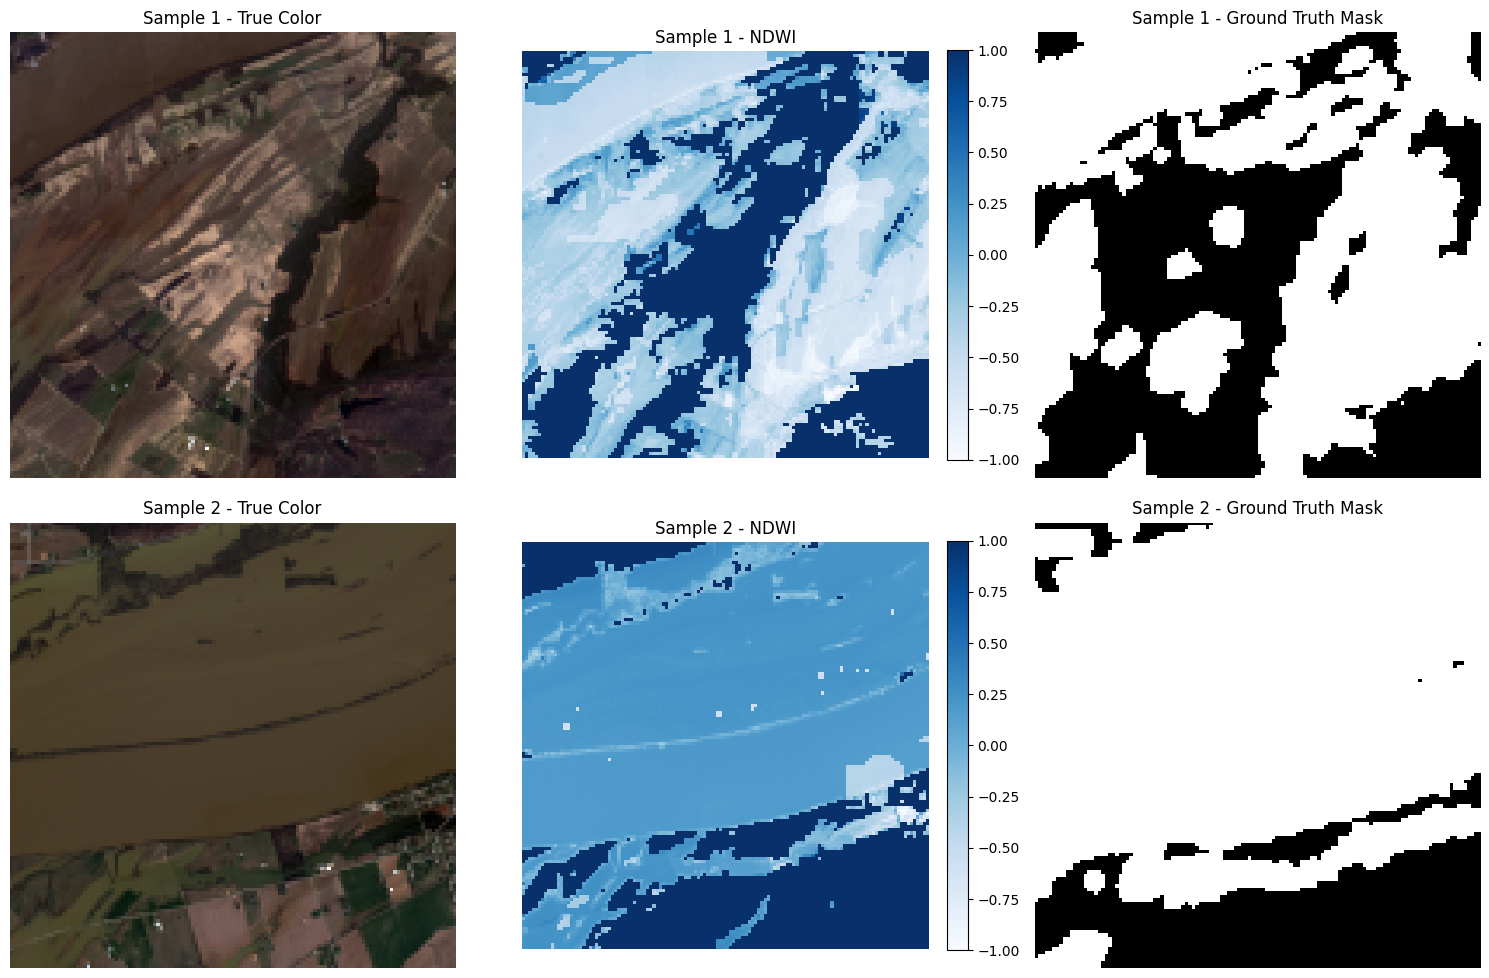

In [51]:
from src.visualize_utils import visualize_image_NDWI
visualize_image_NDWI(X, Y, number_images=2, title_prefix="Sample")

In [52]:
X = np.array(X,'float')  # shape: (num_samples, 128, 128, 12)
Y = np.array(Y,'float')  # shape: (num_samples, 128, 128, 1)

In [53]:
X.shape, Y.shape

((306, 128, 128, 12), (306, 128, 128, 1))

# Save Images and Labels int Numpy Array 

In [55]:
np.save('../data/processed/images_all_bands_data.npy',X)  # Save images
np.save('../data/processed/mask_all_bands_data.npy',Y)  # Save mask
print("Done")

Done
